# Generative Adversarial Networks (GANs)

This colab notebook is an introduction to GANs with simple implementations

![alt text](https://pathmind.com/images/wiki/GANs.png)

### some demos of GANs
https://thispersondoesnotexist.com/<br>
https://thiscatdoesnotexist.com/<br>
https://thisrentaldoesnotexist.com/<br>
https://thiswaifudoesnotexist.com/<br>
and all demos in one place https://thisxdoesnotexist.com/, if you know more add them.

### DCGAN

DCGAN paper: https://arxiv.org/pdf/1511.06434.pdf

![alt text](https://miro.medium.com/max/2000/1*r8AIzUpBcNzpi-JN3gLWtg.png)

### PROGAN

PROGAN paper: https://arxiv.org/pdf/1710.10196.pdf

![alt text](https://i.imgur.com/cCCIZHM.jpg)

### StyleGAN

StyleGAN paper: https://arxiv.org/pdf/1812.04948.pdf

![alt text](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2019/06/Summary-of-the-StyleGAN-Generator-Model-Architecture.png)

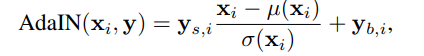

Let's look at StyleGan video to understand what happens: https://www.youtube.com/watch?v=kSLJriaOumA

In [1]:
%tensorflow_version 2.x
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout,LeakyReLU
from tensorflow.keras.layers import BatchNormalization, Activation, ZeroPadding2D
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import time
import tensorflow
import os
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from sklearn.utils import shuffle

TensorFlow 2.x selected.


In [0]:
tensorflow.keras.mixed_precision.experimental.set_policy('float32')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
%%time
!unzip -q 'drive/My Drive/AI Bootcamp/Courses/GAN Workshop/carpet_aug.zip'

CPU times: user 54.9 ms, sys: 12.4 ms, total: 67.3 ms
Wall time: 6.94 s


In [0]:
files = os.listdir('carpet_aug')

In [6]:
X_train = np.array([np.array(PIL.Image.open('carpet_aug/'+fname)) for fname in tqdm(files)])

100%|██████████| 7981/7981 [00:05<00:00, 1536.79it/s]


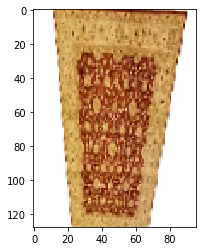

In [7]:
plt.imshow(np.array(PIL.Image.open('carpet_aug/'+files[8])))

Main part of code is from https://github.com/eriklindernoren/Keras-GAN

In [0]:
class DCGAN():
    def __init__(self, img_width, img_height, img_channels):
        # Input shape
        self.img_rows = img_width
        self.img_cols = img_height
        self.channels = img_channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(256 * (self.img_rows/32) * (self.img_cols/32), activation="relu", input_dim=self.latent_dim))
        model.add(Reshape(((self.img_rows//32), (self.img_cols//32), 256)))
        model.add(UpSampling2D()) #6,8
        
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D()) #12,16
         
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D()) #24,32
                
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D()) #48,64
        
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D()) #96,128
        
        model.add(Conv2D(32, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(64, kernel_size=3, strides=1, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))
        
        model.add(Conv2D(64, kernel_size=3, strides=1, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))
        
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))
        
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))
        
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))
        
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))
        
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self,X_train, epochs, batch_size=128, save_interval=1):

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.

        start = time.time()
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------
            
            #shuffle data
            X_train = shuffle(X_train)
            for c in range(X_train.shape[0]//batch_size+1):
                # Select a batch
                imgs = X_train[c*batch_size:(c+1)*batch_size]

                # Sample noise and generate a batch of new images
                noise = np.random.normal(0, 1, (imgs.shape[0], self.latent_dim))
                gen_imgs = self.generator.predict(noise)
                # Adversarial ground truths
                valid = np.ones((imgs.shape[0], 1))
                fake = np.zeros((imgs.shape[0], 1))

                # Train the discriminator (real classified as ones and generated as zeros)
                d_loss_real = self.discriminator.train_on_batch(imgs, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
                #print(d_loss_real,d_loss_fake)
                # ---------------------
                #  Train Generator
                # ---------------------

                # Train the generator (wants discriminator to mistake images as real)
                g_loss = self.combined.train_on_batch(noise, valid)
                elapsed = time.time()-start
                time_elapsed = str(int(elapsed//3600))+':'+str(int(elapsed%3600//60))+':'+str(int(elapsed%60))
                # Plot the progress
                print ("""epoch {}, time elapsed {},
                          batch {}/{} [D loss: {},
                          acc. on fake: {}] [G loss: {}]""".format(epoch,time_elapsed,c,
                                                           X_train.shape[0]//batch_size+1,
                                                           d_loss[0],100*d_loss_fake[1],g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images to 0-255
        gen_imgs = ((gen_imgs + 1)*127.5).astype(int)

        fig, axs = plt.subplots(r, c, figsize=(20,20))
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("drive/My Drive/AI Bootcamp/GAN_generated_small/carpet_{}.png".format(epoch+1))
        #plt.show()
        plt.close()

In [9]:
dcgan = DCGAN(128, 96, 3)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 96, 64)       1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 128, 96, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 96, 64)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 96, 64)       36928     
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 129, 97, 64)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 129, 97, 64)       256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 129, 97, 64)       0

In [10]:
dcgan.train(X_train,epochs = 5000, batch_size = 64)

epoch 0, time elapsed 0:2:57,
                          batch 0/125 [D loss: 96.38308715820312,
                          acc. on fake: 0.0] [G loss: 6.377472345775459e-07]


KeyboardInterrupt: ignored